# Effective Dimension of Qiskit Neural Networks
In this tutorial, we will take advantage of the `EffectiveDimension` and `LocalEffectiveDimension` classes to evaluate the power of Quantum Neural Network models. These are metrics based on information geometry that connect to notions such as trainability, expressibility or ability to generalize.

Before diving into the code example, we will briefly explain what is the difference between these two metrics, and why are they relevant to the study of Quantum Neural Networks. More information about global effective dimension can be found in [this paper](https://arxiv.org/pdf/2011.00027.pdf), while the local effective dimension was introduced in a [later work](https://arxiv.org/abs/2112.04807).

## 1. Global vs. Local Effective Dimension
Both classical and quantum machine learning models share a common goal: being good at **generalizing**, i.e. learning insights from data and applying them on unseen data.

Finding a good metric to assess this ability is a non-trivial matter. In [The Power of Quantum Neural Networks](https://arxiv.org/pdf/2011.00027.pdf), the authors introduce the **global** effective dimension as a useful indicator of how well a particular model will be able to perform on new data.

The key difference between global and **local** effective dimension is actually not in the way they are computed, but in the nature of the parameter space that is analyzed. The global effective dimension incorporates the **full parameter space** of the model, and is calculated from a **large number of parameters sets**. On the other hand, the local effective dimension focuses on how well the **trained** model can generalize to new data, and thus only requires **1** set of parameters values (training result) for its calculation. This difference is small in terms of practical implementation, but quite relevant at a conceptual level.

## 2. The Effective Dimension Algorithm

Both the global and local effective dimension algorithms use the Fisher Information matrix to provide a measure of complexity. The details on how this matrix is calculated are provided in the [reference paper](https://arxiv.org/pdf/2011.00027.pdf), but in general terms, this matrix captures how sensitive a neural network's output is to changes in the network's parameter space.

In particular, this algorithm follows 4 main steps:

1. **Monte Carlo simulation:** the forward and backward passes (gradients) of the neural network are computed for each pair of input samples-parameter sets.
2. **Fisher Matrix Computation:** these outputs and gradients are used to compute the Fisher Information Matrix.
3. **Fisher Matrix Normalization:** averaging over all input samples and dividing by the matrix trace
4. **Effective Dimension Calculation:** according to the formula from [*Abbas et al.*](https://arxiv.org/pdf/2011.00027.pdf)

## 3. Basic Example (CircuitQNN)

This example shows how to set up a QNN model problem and run the global effective dimension algorithm. Both Qiskit `CircuitQNN` (shown in this example) and `OpflowQNN` (shown in a later example) can be used with the `EffectiveDimension` class.

We start off from the required imports and a fixed seed for the random number generator for reproducibility purposes.

In [1]:
# Necessary imports
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes
import matplotlib.pyplot as plt
import numpy as np

from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer, QuantumCircuit

from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA

# set random seed
algorithm_globals.random_seed = 12345

The first step to create a `CircuitQNN` is to define a parametrized feature map and ansatz. In this toy example, we will use 3 qubits, and we will define the circuit used in the `TwoLayerQNN` class.

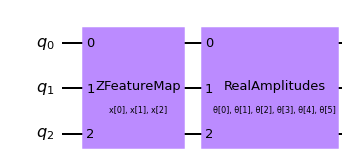

In [2]:
num_qubits = 3
# create a feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
# create a variational circuit
ansatz = RealAmplitudes(num_qubits, reps=1)

# combine feature map and ansatz into a single circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))
qc.decompose().draw("mpl")

The parametrized circuit can then be sent together with an optional interpret map (parity in this case) to the `CircuitQNN` constructor.

In [3]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [4]:
# declare quantum instance
qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

# construct QNN
qnn = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
    quantum_instance=qi_sv,
)

### 3.1 Define the Problem

In order to define the problem, we need a series of sets of input samples and weights, as well as the total number of data samples available in a dataset. The `input_samples` and `weight_samples` are set in the class constructor, while the number of data samples is given during the call to the effective dimension computation to be able to test and compare how this measure changes with different dataset sizes.

We also define a callback to see how long each QNN pass takes during the Monte Carlo simulation. The callback takes three parameters: iteration, the time spent on the forward pass of the neural network, and the time spent on the backward pass.

In [5]:
def callback(i, f, b):
    print(f"Iteration: {i}, forward time: {f}, backward time: {b}")

We can define the number of input samples and weight samples and the class will randomly sample a corresponding array from a normal (for `input_samples`) or a uniform (for `weight_samples`) distribution. Instead of passing a number of samples you can pass an array, sampled manually.

In [6]:
# we can set the total number of input samples and weight samples for random selection
num_input_samples = 10
num_weight_samples = 10

global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples, callback=callback
)

If we want to test a specific set of input samples and weight samples, we can provide it directly to the `EffectiveDimension` class as shown in the following snippet:

In [7]:
# we can also provide user-defined samples and parameters
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=weight_samples, input_samples=input_samples, callback=callback
)

The effective dimension algorithm also requires a dataset size. In this example, we will define an array of sizes to later see how this input affects the result.

In [8]:
# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

### 3.2 Compute the Global Effective Dimension
Let's now calculate the effective dimension of our network for the previously defined set of input samples, weights, and a dataset size of 5000. The previously defined callback function will show the time each pass takes in the Monte Carlo simulation.

In [9]:
global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

Iteration: 0, forward time: 0.05884218215942383, backward time: 0.5136253833770752
Iteration: 1, forward time: 0.03390955924987793, backward time: 0.5681490898132324
Iteration: 2, forward time: 0.03490614891052246, backward time: 0.49821901321411133
Iteration: 3, forward time: 0.03789710998535156, backward time: 0.4677863121032715
Iteration: 4, forward time: 0.03287458419799805, backward time: 0.499129056930542
Iteration: 5, forward time: 0.03598427772521973, backward time: 0.43074703216552734
Iteration: 6, forward time: 0.032950401306152344, backward time: 0.45773863792419434
Iteration: 7, forward time: 0.03195381164550781, backward time: 0.5385444164276123
Iteration: 8, forward time: 0.03593635559082031, backward time: 0.46730875968933105
Iteration: 9, forward time: 0.03844618797302246, backward time: 0.5934057235717773


The effective dimension values will range between 0 and `d`, where `d` represents the dimension of the model, and it's practically obtained from the number of weights of the QNN. By dividing the result by `d`, we can obtain the normalized effective dimension, which correlates directly with the capacity of the model.

In [10]:
d = qnn.num_weights

print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
print(
    "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
)

Data size: 5000, global effective dimension: 4.5225
Number of weights: 6, normalized effective dimension: 0.7537


By calling the `EffectiveDimension` class with an array if input sizes `n`, we can monitor how the effective dimension changes with the dataset size.

In [11]:
global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)

Iteration: 0, forward time: 0.03291034698486328, backward time: 0.4897336959838867
Iteration: 1, forward time: 0.03188180923461914, backward time: 0.4249863624572754
Iteration: 2, forward time: 0.036901235580444336, backward time: 0.43679380416870117
Iteration: 3, forward time: 0.032953739166259766, backward time: 0.491727352142334
Iteration: 4, forward time: 0.029957294464111328, backward time: 0.46939682960510254
Iteration: 5, forward time: 0.0359041690826416, backward time: 0.518648624420166
Iteration: 6, forward time: 0.030881881713867188, backward time: 0.4308803081512451
Iteration: 7, forward time: 0.02992868423461914, backward time: 0.51320481300354
Iteration: 8, forward time: 0.032912254333496094, backward time: 0.6034197807312012
Iteration: 9, forward time: 0.03790450096130371, backward time: 0.45487284660339355


In [12]:
print("Effective dimension: {}".format(global_eff_dim_1))
print("Number of weights: {}".format(d))

Effective dimension: [4.52247524 4.59774644 4.63344369 4.84126458 4.89538546 4.95874772
 5.00527843 5.03635004 5.12536624 5.18369908]
Number of weights: 6


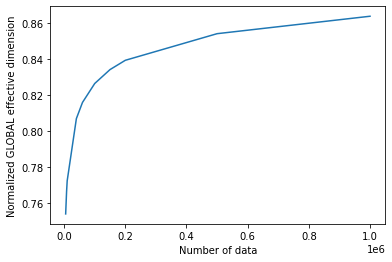

In [13]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim_1) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()

## 4. Local Effective Dimension Example
As explained in the introduction, the local effective dimension algorithm only uses **one** set of weights. The `LocalEffectiveDimension` class enforces this constraint to ensure that these calculations are conceptually separate, but the rest of the implementation is shared with the `EffectiveDimension` class.

Let's see how the `LocalEffectiveDimension` changes when we train a QNN for classification. First, we create a classification dataset.

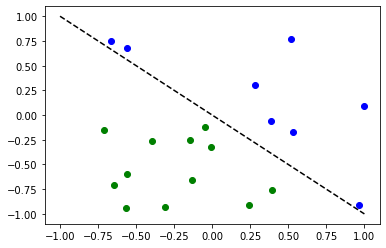

In [14]:
num_inputs = 2
num_samples = 20

X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

The next step is to create a QNN, an instance of `TwoLayerQNN` in our case. Since we pass only the number of inputs, the network will continue with the default values for feature map and ansatz.

In [15]:
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=qi_sv)

The training step may take some time, be patient. You can pass a callback to the classifier to observe how the training process is going on. We fix `initial_point` for reproducibility purposes as usual.

In [16]:
initial_point = algorithm_globals.random.random(opflow_qnn.num_weights)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=opflow_qnn, optimizer=COBYLA(), initial_point=initial_point
)

# fit classifier to data
circuit_classifier.fit(X, y)
circuit_classifier.score(X, y)

0.75

Now, we evaluate local effective dimension using only one randomly sampled set of weights.

In [17]:
random_weights = algorithm_globals.random.uniform(0, 1, size=(1, opflow_qnn.num_weights))

local_ed_random = LocalEffectiveDimension(
    qnn=opflow_qnn, weight_samples=random_weights, input_samples=X  # send only one set of weights
)
local_eff_dim_random = local_ed_random.get_effective_dimension(dataset_size=n)

In contrast to what we did in the previous step, here we evaluate effective dimension based on the trained weights. To do that we access the trained weights directly from the classifier.

In [18]:
trained_weights = circuit_classifier._fit_result.x

# Get Local Effective Dimension for set of trained weights
local_ed_trained = LocalEffectiveDimension(
    qnn=opflow_qnn,
    weight_samples=trained_weights,
    input_samples=X,  # send only one set of parameters
)

local_eff_dim_trained = local_ed_trained.get_effective_dimension(dataset_size=n)

In [19]:
print(local_eff_dim_random)
print(local_eff_dim_trained)

[4.42401236 4.38614139 4.37050301 4.29637571 4.28002788 4.26182281
 4.24896043 4.24056525 4.21718048 4.20225309]
[4.16348723 4.14609872 4.13923652 4.10889094 4.10258867 4.09568707
 4.09087072 4.08774872 4.07912035 4.07364939]


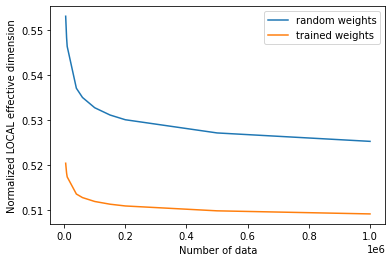

In [20]:
# plot the normalized effective dimension for the model
d = opflow_qnn.num_weights

plt.plot(n, np.array(local_eff_dim_random) / d, label="random weights")  # random
plt.plot(n, np.array(local_eff_dim_trained) / d, label="trained weights")  # trained
plt.legend()
plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.show()

We can see from the graph above that the trained weights lead to a higher local effective dimension, because the ability to classify new data points is higher. Following this example, we can establish comparisons between different  model architectures (for a fixed input dataset), optimizers... And try to find the combination that maximizes the local effective dimension.

In [30]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright